<h3 style="text-align: center;"><b>Transfer Learning</b></h3>

---

В зависимости от количества и природы данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* **мало данных** ($\le$ 10k) и они **похожи** на данные, на которых была обучена сеть до этого:  
  - Если данные совсем похожи, можно попробовать использовать готовую модель. Если качество не устраивает, то тогда стоит использовать CNN для извлечения признаков и обучить свой классификатор на этих данных. Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning, то сеть может переобучиться, поскольку данных мало.
* **мало данных** ($\le$ 10k) и они **не похожи** на данные, на которых была обучена сеть до этого:  
  - Здесь мы не можем ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует также действовать как и в пункте выше, но брать как признаки выходы более ранних слоёв, ведь, как мы помним, они (как ожидается) соответствуют более общим паттернам в данных.
* **много данных** ($\ge$ 10k) и они **похожи** на данные, на которых была обучена сеть до этого:
  - В этом случае можем смело делать Fine-Tuning (если не устроило качество модели "из коробки"), ведь данных много, и вероятность переобучения меньше. В данном случае имеет смысл разморозить веса последних нескольких слоёв.
* **много данных** ($\ge$ 10k) и они **не похожи** на данные, на которых была обучена сеть до этого:
  - В этом случае можно полностью менять все параметры (и гиперпараметры) нейросети, ведь по сути мы пользуемся только её архитектурой, забывая о том, что она уже была когда-то обучена. Но часто веса предобученной сети оставляют в качестве инициализации для обучения на новых данных.



# Install packages

---

Первым делом установим необходимые библиотеки. Среда Google Colab имеет особенность в плане совместимостей версий, поэтому порой бывает необходимо установить определенную версию того или иного пакета.

In [1]:
# !pip install -U albumentations
# !pip uninstall opencv-python
# !pip uninstall opencv-contrib-python
# !pip install opencv-contrib-python==4.5.5.62
# !pip install -q --upgrade wandb
# !pip install timm
# !pip install -q torchinfo

# Import Libraries

---

In [2]:
from collections import OrderedDict
import multiprocessing
import os
from pathlib import Path
import platform
import random
import sys
import time
import warnings
warnings.filterwarnings("ignore")

import albumentations as A
import albumentations.pytorch as AP

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import timm

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torch._dynamo import config
config.numpy_default_float = "float32"
config.suppress_errors = True

from torchinfo import summary

import torchvision
from torchvision import datasets, models, transforms

import wandb

## Library Versions and System Information

---

In [3]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_available() and torch.backends.mps.is_built()
DEVICE = torch.device("mps" if has_mps else ("gpu" if has_gpu else "cpu"))

torch.set_num_threads(1)
cv2.setNumThreads(1)

NUM_WORKERS = multiprocessing.cpu_count()

TRAIN = "train"
VALID = "valid"

In [156]:
def time_synchronized() -> float:
    if torch.backends.mps.is_available():
        torch.mps.synchronize()
    elif torch.cuda.is_available():
        torch.cuda.synchronize()
    return time.time()


def check_device() -> None:
    input_random = torch.rand(8, 512, 112, 112).to(DEVICE)
    
    start = time_synchronized()
    _ = nn.Conv2d(512, 1024, 3, groups=1, device=DEVICE)(input_random)
    print(f"Normal convolution take  {time_synchronized() - start:.2f} sec.")
    
    start = time_synchronized()
    _ = nn.Conv2d(512, 1024, 3, groups=64, device=DEVICE)(input_random)
    print(f"Groupped convolution take  {time_synchronized() - start:.2f} sec.")


def print_lib_info() -> None:
    print(f"Python Platform: {platform.platform()}")
    print(f"Python {sys.version}", end="\n\n")
    print(f"Albumentations {A.__version__}")
    print(f"OpenCV {cv2.__version__}")
    print(f"PyTorch Version: {torch.__version__}")
    try:
        from torchinfo import summary
    except ImportError:
        print("\n[INFO] Couldn't find torchinfo... installing it\n")
        raise SystemExit(os.system("pip install torchinfo"))
    print(f"timm {timm.__version__}")
    print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
    print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE", end="\n\n")
    print(f"Target device is {DEVICE.type}")
    print(f"CPU count: {NUM_WORKERS}")
    check_device()


print_lib_info()

Python Platform: macOS-14.0-arm64-arm-64bit
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]

Albumentations 1.3.1
OpenCV 4.8.1
PyTorch Version: 2.2.0.dev20231019
timm 0.9.7
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE

Target device is mps
CPU count: 10
Normal convolution take  2.74 sec.
Groupped convolution take  1.90 sec.


### Albumentations & timm

---



| **Название** | **Назначение** | **Ссылка** |
| ----- | ----- | ----- |
| **`timm`** | Все новейшие и лучшие модели компьютерного зрения на PyTorch, собранные в одном месте. | https://github.com/rwightman/pytorch-image-models|
| **`Albumentations`** | Самая обширная коллекция всевозможных аугментаций для компьютерного зрения, быстрая и удобная в использовании. | https://albumentations.ai/ |

## Options

---

Зафиксируем seed для воспроизводимости:

In [30]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.mps.manual_seed(seed)

**CFG** - класс с параметрами нашего эксперимента:

In [190]:
class CFG:
    debug = False

    seed = 42
    
    file_type = "*.JPEG"
    
    img_height = 160
    img_width = 160
    img_mean = np.array([0.485, 0.456, 0.406])
    img_std = np.array([0.229, 0.224, 0.225])
    
    model_name = "resnet50"

    size = 224
    epochs = 30
    batch_size = 8
    
    lr = 1e-4 # 3e-4
    min_lr = 1e-6
    
    scheduler = ["StepLR", 
                 "ReduceLROnPlateau", 
                 "CosineAnnealingLR", 
                 "CosineAnnealingWarmRestarts"]
    
    step_size = 20  # StepLR
    gamma = 0.1  # StepLR
    factor = 0.2  # ReduceLROnPlateau
    patience = 4  # ReduceLROnPlateau
    eps = 1e-6  # ReduceLROnPlateau
    T_max = 6  # CosineAnnealingLR
    T_0 = 6  # CosineAnnealingWarmRestarts

    api = "dbb6635241c38b58fc16b91872f6bfb162ba63e0"
    project = "FashionMNIST"
    entity = "otofarings"
    wandb = False

Функция перевода класса конфигурации в словарь:

In [7]:
def class2dict(f_):
    return dict((name, getattr(f_, name)) for name in dir(f_) if not name.startswith("__"))

# Description

---

Архитектура Residual Networks, остается золотым стандартом в многочисленных научных публикациях. Как правило, они используются в исследованиях по умолчанию или служат базовыми при разработке новых архитектур. Однако с момента появления архитектуры ResNet в 2015 году произошел значительный прогресс в области лучших практик обучения нейронных сетей. Новые методы оптимизации и дополнения данных повысили эффективность рецептов обучения. В данной работе мы повторно оцениваем производительность ванильной ResNet-50 при обучении с использованием процедуры, учитывающей эти достижения. Мы используем параметры для обучения и предварительно обученные модели в библиотеке с открытым исходным кодом timm, надеясь, что они послужат лучшими исходными данными для дальнейшей работы.

[ResNet strikes back: An improved training procedure in timm](https://arxiv.org/abs/2110.00476)

**Цель:** Добиться 98% точности на тестовом наборе датасета imagenette10.

**Описание:**
Данный датасет представляет собой набор картинок 10 классов из датасета ImageNet, подробнее [тут](https://github.com/fastai/imagenette).

Набор данных содержит 9 469 обучающих и 3 925 валидационных изображений (разрешение 160×160).

Классы:
1. tench, 
2. English springer, 
3. cassette player, 
4. chain saw, 
5. church, 
6. French horn, 
7. garbage truck, 
8. gas pump, 
9. golf ball, 
10. parachute

# Classification on imagenette10

---

In [160]:
# Загружаем датасет
dataset_path = "imagenette2-160/"
if not os.path.exists(dataset_path):
    if not os.path.exists("imagenette2-160.tgz"):
        !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
    !tar zxvf imagenette2-160.tgz

TRAIN_DIR = os.path.exists(Path(f"{dataset_path}train/"))
VAL_DIR = os.path.exists(Path(f"{dataset_path}val/"))

Для успешного решения данной задачи нам потребуется 2 новые библиотеки: **Albumentations** и **PyTorch image models (timm)**.

## Subtask №1

---

Изучим внимательно виды аугментаций, представленных в библиотеке `Albumentations` и напишем функцию с ними.

### Albumentations

---

Функция с аугментациями:

In [10]:
def get_transforms(data_type_: str) -> A.Compose:
    if data_type_ == TRAIN:
        params = [
            A.Transpose(p=0.5),
            A.OpticalDistortion(),
            A.GridDistortion(),
            A.Blur(blur_limit=3, p=0.6),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1)
            ], p=0.6),
            A.Resize(CFG.size, CFG.size, always_apply=True),
            A.Normalize(mean=CFG.img_mean, std=CFG.img_std, always_apply=True),
            AP.transforms.ToTensorV2(always_apply=True)
        ]
    
    elif data_type_ == VALID:
        params = [
            A.Resize(CFG.size, CFG.size, always_apply=True),
            A.Normalize(mean=CFG.img_mean, std=CFG.img_std, always_apply=True),
            AP.transforms.ToTensorV2(always_apply=True)
        ]
    
    else:
        raise ValueError(f"Data type {data_type_} is not supported")
    
    return A.Compose(params)

### MakeDataset

---

**MakeDataset** - класс для создания датасета

Поскольку у нас нестандартные аугментации, нам придется несколько переписать стандартный модуль Dataset.

In [12]:
class MakeDataset(Dataset):
    def __init__(self, files, transform=None):
        super(MakeDataset, self).__init__()
        self.files = files
        self.labels = [path.parent.name for path in self.files]
        self.len_ = len(self.files)
        self.transform = transform
        self.classes_names = {
            "n01440764": "tench",
            "n02102040": "English springer",
            "n02979186": "cassette player",
            "n03000684": "chain saw",
            "n03028079": "church",
            "n03394916": "French horn",
            "n03417042": "garbage truck",
            "n03425413": "gas pump",
            "n03445777": "golf ball",
            "n03888257": "parachute"
        }
        self.classes = np.array([key for key in self.classes_names.keys()], dtype=str)

    def __len__(self) -> int:
        return self.len_

    def __getitem__(self, index_: int) -> tuple:
        return self._transform_img(self._preprocess_img(index_)), self._get_id_by_label(index_)
    
    def _preprocess_img(self, index_: int) -> np.ndarray:
        return cv2.cvtColor(cv2.imread(str(self.files[index_])), cv2.COLOR_BGR2RGB)
    
    def _transform_img(self, image_: np.ndarray) -> torch.Tensor:
        return self.transform(image=image_)["image"] if self.transform else image_
    
    def _get_id_by_label(self, index_: int) -> int:
        return next(i for i, x in enumerate(self.classes) if x == self.labels[index_])
    
    def get_class_name(self, class_id: int) -> str:
        return self.classes_names[self.classes[class_id]]

### Load Dataset

---

Рекурсивно обойдем все папки с изображениями

In [13]:
train_files = sorted(list(TRAIN_DIR.rglob(CFG.file_type)))
val_files = sorted(list(VAL_DIR.rglob(CFG.file_type)))

In [14]:
train_dataset = MakeDataset(train_files, get_transforms(TRAIN))
val_dataset = MakeDataset(val_files, get_transforms(VALID))

### Show Dataset

---

Посмотрим, как выглядят наши картинки уже после применения к ним аугментаций.


In [15]:
def show_dataset(dataset_, n=3):
    def _convert_img(img_):
        return np.clip(np.array(CFG.img_std) * img_.transpose((1, 2, 0)) + np.array(CFG.img_mean), 0, 1)

    def _tensor_fn(img_):
        with torch.device(DEVICE):
            img = _convert_img(img_.numpy())
        return torch.from_numpy(img)
    
    def _imshow(fig_x_: plt.Axes):
        img, label = _slice_dataset()
        class_name = dataset_.get_class_name(label)
        
        fig_x_.imshow(_tensor_fn(img))
        if class_name is not None:
            fig_x_.set_title(class_name)
        fig_x_.grid(False)
    
    def _slice_dataset() -> tuple:
        return dataset_[int(np.random.uniform(0, len(dataset_)))]
    
    def _iter_ax(ax_) -> list:
        return [_imshow(fig_x) for fig_x in ax_.flatten()]

    fig, ax = plt.subplots(
        nrows=n, 
        ncols=n, 
        figsize=(10, 10), 
        sharey=True, 
        sharex=True
    )
    _iter_ax(ax)

    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    
    plt.show()

Выведем несколько картинок из обучающего и валидационного набора данных, чтобы проверить, что все работает корректно.

#### Sample of Train Dataset

---

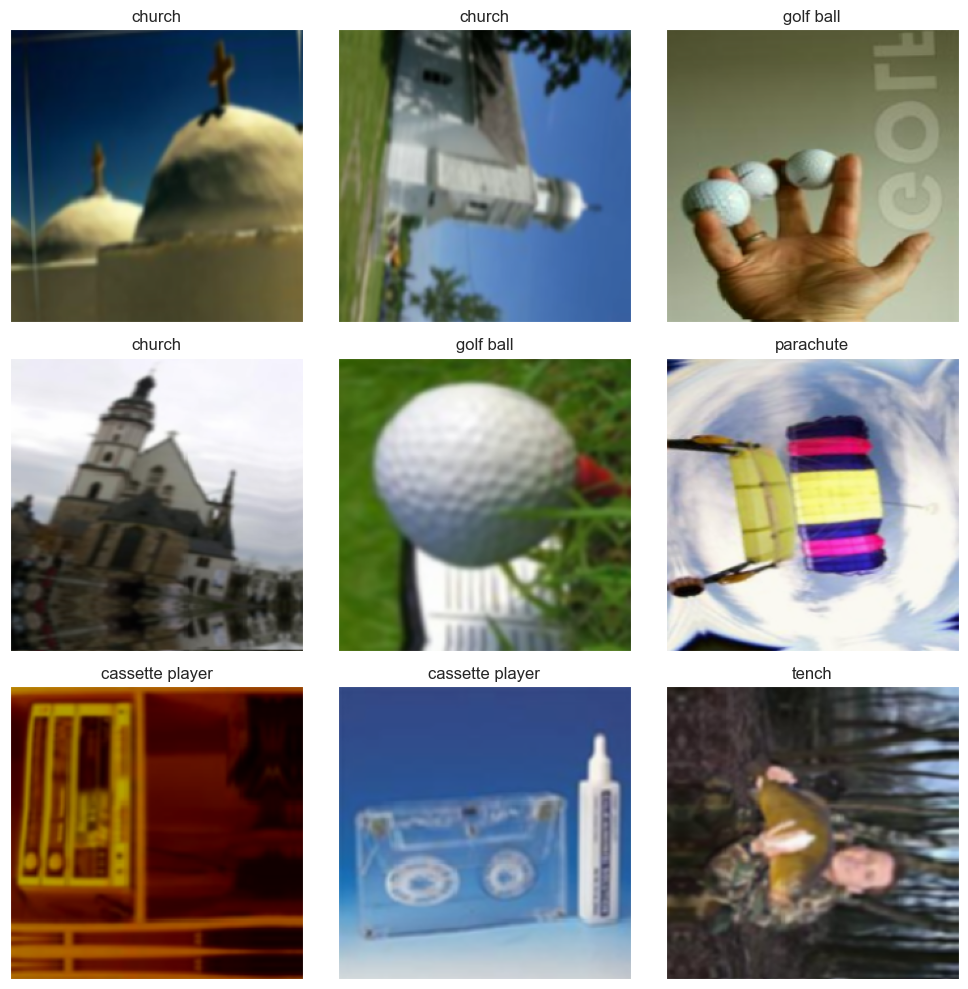

In [16]:
show_dataset(train_dataset)

#### Sample of Valid Dataset

---

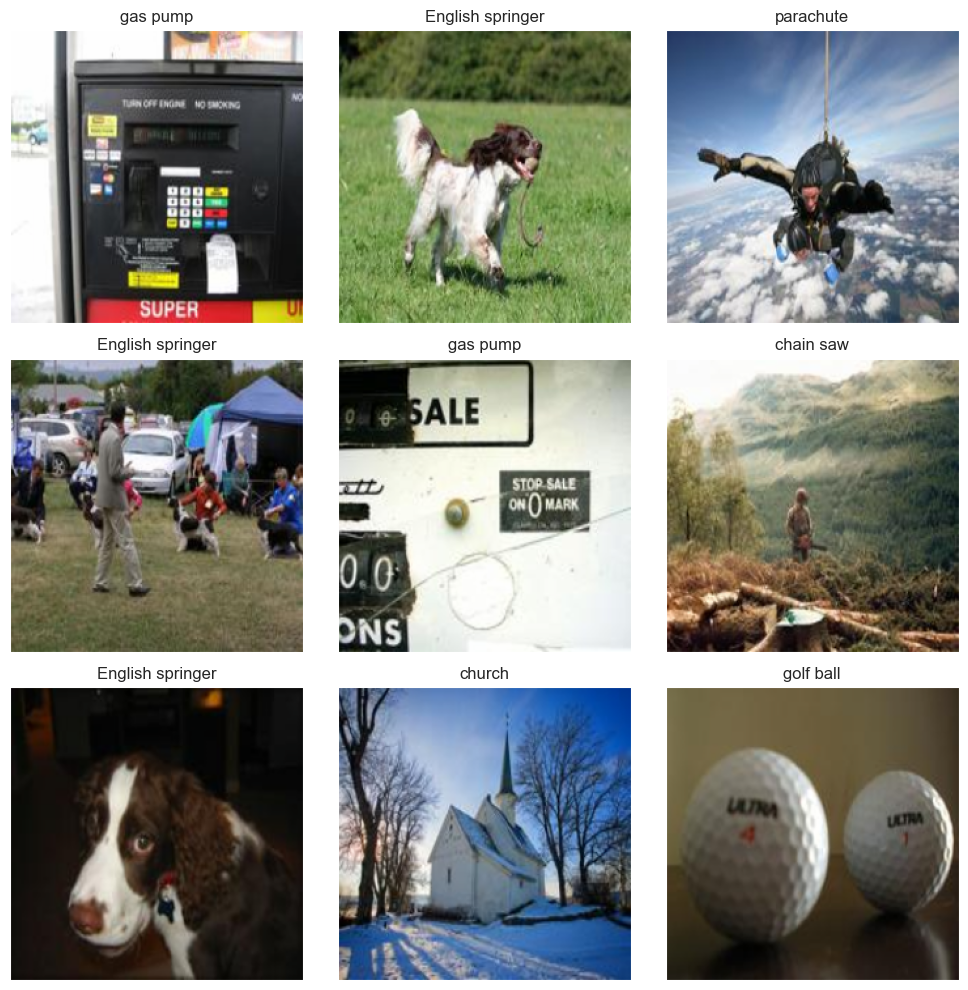

In [17]:
show_dataset(val_dataset)

### DataLoader

---

In [163]:
def create_data_loader(data_type_: str) -> DataLoader:
    return DataLoader(
        dataset=train_dataset if data_type_ == TRAIN else val_dataset,
        batch_size=CFG.batch_size,
        shuffle=True if data_type_ == TRAIN else False,
        num_workers=0
    )

#### Batch Size

---

Поскольку мы используем аугментации, то нам необходимо увеличить размер батча, чтобы уменьшить вероятность переобучения.
В данный момент мы используем батч размером 8, но в реальных задачах это число может быть больше.
К примеру в [этой статье](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU) авторы утверждают, что оптимальный размер батча равен 32. Тогда как размеры 8 и 2048 считаются вариантами хуже.

In [165]:
train_loader = create_data_loader(TRAIN)
valid_loader = create_data_loader(VALID)

print("Train and Valid datasets are loaded:\n")
print("{:<7s}{:>10s}{:>10s}".format("Dataset", "Batches", "Pictures")), print("-" * 28)
print("{:<7s}{:>10d}{:>10d}".format(TRAIN.capitalize(), len(train_loader), len(train_dataset)))
print("{:<7s}{:>10d}{:>10d}".format(VALID.capitalize(), len(valid_loader), len(val_dataset)))

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train        1184      9469
Valid         491      3925


### Wandb

---

Для ведения логов и отслеживания метрик будем использовать библиотеку `wandb`.

In [166]:
def start_wandb() -> None:
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(
            project=CFG.project,
            name=CFG.model_name,
            entity=CFG.entity,
            reinit=True,
            config=class2dict(CFG)
        )


def write_wandb(phase_: str, epoch_loss_: float, epoch_acc_: float) -> None:
    if CFG.wandb:
        wandb.log({
            f"{phase_}_loss": epoch_loss_,
            f"{phase_}_accuracy": epoch_acc_
        })

### Model

---

Функция обучения и инференса модели:

In [183]:
def train_val_model(model_, loss_, optimizer_, scheduler_, num_epochs_: int) -> tuple:
    
    def _print_stats(phase_: str) -> None:
        write_wandb(phase_, hist_dct["loss"][phase_][-1], hist_dct["acc"][phase_][-1])
        print(f"{phase_} loss: {hist_dct['loss'][phase_][-1]:.2f} accuracy: {hist_dct['acc'][phase_][-1]:.2f}")

    def _prepare_dataloader(phase_: str) -> DataLoader:
        
        def prepare_train() -> DataLoader:
            scheduler_.step()
            model_.train(mode=(phase == TRAIN))
            return train_loader
        
        def prepare_valid() -> DataLoader:
            model_.eval()
            return valid_loader
        
        return prepare_train() if phase_ == TRAIN else prepare_valid()
    
    def _calc_grad(phase_: str, inputs_: torch.Tensor, labels_: torch.Tensor) -> tuple:

        def step_grad(loss_value: torch.Tensor):
            if phase_ == TRAIN:
                loss_value.backward()
                optimizer_.step()
            
        optimizer_.zero_grad()  # Обнуляем градиент, чтобы он не накапливался
        with torch.set_grad_enabled(phase_ == TRAIN):  # Если фаза train, активируем все градиенты (не замороженные)
            output = model_(inputs_)  # Считаем предикты, input передаем в модель
            loss_value_ = loss_(output, labels_)  # Посчитали  Loss
            pred_class = output.argmax(dim=1)  # Получаем класс, берем нейрон с максимальной активацией
            step_grad(loss_value_)  # Считаем градиент и шаг градиентного спуска
        return loss_value_.item(), (pred_class == labels_.data).float().mean().data.cpu().numpy()
    
    start_wandb()
    seed_everything(CFG.seed)
    hist_dct = {"loss": {TRAIN: [], VALID: []}, "acc": {TRAIN: [], VALID: []}}
    best_accuracy = 0.
    for epoch in range(num_epochs_):
        print(f"Epoch {epoch + 1}/{num_epochs_}:", end="\n")
        for phase in [TRAIN, VALID]:
            dataloader = _prepare_dataloader(phase)
            running_loss, running_accuracy = 0., 0.
            
            for inputs, labels in tqdm(dataloader):
                grad_result = _calc_grad(phase, inputs.to(DEVICE), labels.to(DEVICE))
                running_loss += grad_result[0]
                running_accuracy += grad_result[1]

            hist_dct["loss"][phase].append(running_loss / len(dataloader))  # Loss'ы делим на кол-во бачей в эпохе
            hist_dct["acc"][phase].append(running_accuracy / len(dataloader))  # Считаем Loss на кол-во бачей в эпохе
            _print_stats(phase)
            
            if (phase == VALID) and (hist_dct["acc"][phase][-1] > best_accuracy):
              best_accuracy = hist_dct["acc"][phase][-1]
              print(f"Epoch {epoch + 1} - Save Best Accuracy: {best_accuracy:.2f} Model {CFG.model_name}\n")
              torch.save(model_.state_dict(), os.path.join("./content", f"{CFG.model_name}.pth"))
    
    return model_, hist_dct["loss"], hist_dct["acc"]

## Subtask №2

---

### timm

---

Изучим внимательно, какие модели есть в библиотеке `timm` и выберем несколько.

Выведем все модели, которые есть в ней есть:

In [48]:
model_lst = timm.list_models("*")
print(*model_lst, sep="\n")
print(f"\nTotal number of models: {len(model_lst)}")

bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convformer_s36
convit_base
conv

Библиотека `timm` содержит в себе 991 модель или вариацию модели.

Изучим подробнее модель `resnet50`:

In [78]:
NUM_CLASSES = len(train_dataset.classes)
model_test = timm.create_model(CFG.model_name, pretrained=True, num_classes=len(train_dataset.classes))
summary(model=model_test,
        input_size=(NUM_CLASSES, 3, 160, 160),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [10, 3, 160, 160]    [10, 10]             --                   True
├─Conv2d: 1-1                            [10, 3, 160, 160]    [10, 64, 80, 80]     9,408                True
├─BatchNorm2d: 1-2                       [10, 64, 80, 80]     [10, 64, 80, 80]     128                  True
├─ReLU: 1-3                              [10, 64, 80, 80]     [10, 64, 80, 80]     --                   --
├─MaxPool2d: 1-4                         [10, 64, 80, 80]     [10, 64, 40, 40]     --                   --
├─Sequential: 1-5                        [10, 64, 40, 40]     [10, 256, 40, 40]    --                   True
│    └─Bottleneck: 2-1                   [10, 64, 40, 40]     [10, 256, 40, 40]    --                   True
│    │    └─Conv2d: 3-1                  [10, 64, 40, 40]     [10, 64, 40, 40]     4,096                True
│    │    └─BatchN

Модель `resnet50` имеет 23 528 522 параметра, из которых все можно обучать. 
Посмотрим на архитектуру модели:

In [80]:
print(dir(model_test))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hoo

Видим, что модель состоит из 4-х основных слоев. Посмотрим на них подробнее:

In [95]:
model_test.named_parameters

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

Будем использовать все слои, кроме последнего. Последний слой заменим на свой.

Проверим статус тренируемости параметров:

In [100]:
for ind, prm in enumerate(model_test.named_parameters()):
    print(ind, prm[0], prm[1].requires_grad)

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.0.conv3.weight True
10 layer1.0.bn3.weight True
11 layer1.0.bn3.bias True
12 layer1.0.downsample.0.weight True
13 layer1.0.downsample.1.weight True
14 layer1.0.downsample.1.bias True
15 layer1.1.conv1.weight True
16 layer1.1.bn1.weight True
17 layer1.1.bn1.bias True
18 layer1.1.conv2.weight True
19 layer1.1.bn2.weight True
20 layer1.1.bn2.bias True
21 layer1.1.conv3.weight True
22 layer1.1.bn3.weight True
23 layer1.1.bn3.bias True
24 layer1.2.conv1.weight True
25 layer1.2.bn1.weight True
26 layer1.2.bn1.bias True
27 layer1.2.conv2.weight True
28 layer1.2.bn2.weight True
29 layer1.2.bn2.bias True
30 layer1.2.conv3.weight True
31 layer1.2.bn3.weight True
32 layer1.2.bn3.bias True
33 layer2.0.conv1.weight True
34 layer2.0.bn1.weight True
35 layer2.0.bn1.bias True
36 l

### Model MyNet

---

Создадим класс для нашей модели, в котором будем менять последние слои.

In [161]:
class MyNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False, efficient_net=False, value=False):
        super(MyNet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=NUM_CLASSES)
        for param in self.model.parameters():
            param.requires_grad = False
        
        if efficient_net:
            fc_inputs = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
            self.model.classifier = nn.Sequential(
                nn.Linear(fc_inputs, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(256, NUM_CLASSES),
                nn.Softmax(dim=1)
            )
                
        else:
            fc_inputs = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(fc_inputs, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.6),
                nn.Linear(256, NUM_CLASSES),
                nn.Softmax(dim=1)
            )

    def forward(self, x):
        return self.model(x)

### Scheduler & Optimizer

---

Определим разные типы изменения скорости обучения и оптимизатор:

In [172]:
def get_scheduler(optimizer_: optim.Optimizer, scheduler_: str) -> optim.lr_scheduler:
        if scheduler_ == "ReduceLROnPlateau":
            return ReduceLROnPlateau(
                optimizer_, 
                mode="min", 
                factor=CFG.factor, 
                patience=CFG.patience, 
                verbose=True, 
                eps=CFG.eps
            )
        elif scheduler_ == "StepLR":
            return StepLR(
                optimizer_, 
                step_size=CFG.step_size, 
                gamma=CFG.gamma
            )
        elif scheduler_ == "CosineAnnealingLR":
            return CosineAnnealingLR(
                optimizer_, 
                T_max=CFG.T_max, 
                eta_min=CFG.min_lr, 
                last_epoch=-1
            )
        elif scheduler_ == "CosineAnnealingWarmRestarts":
            return CosineAnnealingWarmRestarts(
                optimizer_, 
                T_0=CFG.T_0, 
                T_mult=1, 
                eta_min=CFG.min_lr, 
                last_epoch=-1
            )
        else:
            raise ValueError("Invalid scheduler")

### Train with standard parameters

---

Теперь обучим нашу модель с стандартными параметрами, которые мы задали в начале.

#### resnet50

---

- Формат `pretrained=True` - нам нужны веса, которые получились вследствие обучения этой модели на датасете **ImageNet**
- Определяем Loss функцию - в данном случае - это **кросс-энтропия**
- Метод градиентного спуска **AdamW**
- Определяем разные типы изменения скорости обучения

In [ ]:
model = MyNet(CFG.model_name, pretrained=True, efficient_net=False, value=False).to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(optimizer, CFG.scheduler[0])

In [105]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs_=CFG.epochs)

Epoch 1/30:


100%|██████████| 1184/1184 [01:24<00:00, 13.98it/s]


train loss: 2.01 accuracy: 0.48


100%|██████████| 491/491 [00:25<00:00, 19.36it/s]


valid loss: 1.72 accuracy: 0.77
Epoch 1 - Save Best Accuracy: 0.77 Model

Epoch 2/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.50it/s]


train loss: 1.78 accuracy: 0.69


100%|██████████| 491/491 [00:25<00:00, 18.90it/s]


valid loss: 1.59 accuracy: 0.88
Epoch 2 - Save Best Accuracy: 0.88 Model

Epoch 3/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.61it/s]


train loss: 1.71 accuracy: 0.76


100%|██████████| 491/491 [00:26<00:00, 18.86it/s]


valid loss: 1.57 accuracy: 0.90
Epoch 3 - Save Best Accuracy: 0.90 Model

Epoch 4/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.62it/s]


train loss: 1.67 accuracy: 0.80


100%|██████████| 491/491 [00:25<00:00, 19.09it/s]


valid loss: 1.52 accuracy: 0.95
Epoch 4 - Save Best Accuracy: 0.95 Model

Epoch 5/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.94it/s]


train loss: 1.65 accuracy: 0.82


100%|██████████| 491/491 [00:24<00:00, 19.67it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 5 - Save Best Accuracy: 0.96 Model

Epoch 6/30:


100%|██████████| 1184/1184 [01:18<00:00, 15.06it/s]


train loss: 1.63 accuracy: 0.83


100%|██████████| 491/491 [00:24<00:00, 19.66it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 7/30:


100%|██████████| 1184/1184 [01:18<00:00, 15.08it/s]


train loss: 1.63 accuracy: 0.84


100%|██████████| 491/491 [00:24<00:00, 19.67it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 7 - Save Best Accuracy: 0.96 Model

Epoch 8/30:


100%|██████████| 1184/1184 [01:18<00:00, 15.05it/s]


train loss: 1.61 accuracy: 0.85


100%|██████████| 491/491 [00:25<00:00, 19.62it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 8 - Save Best Accuracy: 0.97 Model

Epoch 9/30:


100%|██████████| 1184/1184 [01:18<00:00, 15.01it/s]


train loss: 1.62 accuracy: 0.85


100%|██████████| 491/491 [00:24<00:00, 19.66it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 10/30:


100%|██████████| 1184/1184 [01:18<00:00, 15.04it/s]


train loss: 1.61 accuracy: 0.85


100%|██████████| 491/491 [00:25<00:00, 19.62it/s]


valid loss: 1.49 accuracy: 0.98
Epoch 10 - Save Best Accuracy: 0.98 Model

Epoch 11/30:


100%|██████████| 1184/1184 [01:22<00:00, 14.29it/s]


train loss: 1.61 accuracy: 0.86


100%|██████████| 491/491 [00:25<00:00, 19.35it/s]


valid loss: 1.50 accuracy: 0.97
Epoch 12/30:


100%|██████████| 1184/1184 [01:18<00:00, 15.06it/s]


train loss: 1.60 accuracy: 0.86


100%|██████████| 491/491 [00:24<00:00, 19.77it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 13/30:


100%|██████████| 1184/1184 [01:17<00:00, 15.27it/s]


train loss: 1.60 accuracy: 0.86


100%|██████████| 491/491 [00:24<00:00, 19.81it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 14/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.86it/s]


train loss: 1.60 accuracy: 0.86


100%|██████████| 491/491 [00:25<00:00, 18.96it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 15/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.89it/s]


train loss: 1.60 accuracy: 0.87


100%|██████████| 491/491 [00:25<00:00, 19.21it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 16/30:


100%|██████████| 1184/1184 [01:20<00:00, 14.76it/s]


train loss: 1.60 accuracy: 0.87


100%|██████████| 491/491 [00:24<00:00, 19.67it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 17/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.90it/s]


train loss: 1.59 accuracy: 0.87


100%|██████████| 491/491 [00:26<00:00, 18.74it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 18/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.56it/s]


train loss: 1.59 accuracy: 0.87


100%|██████████| 491/491 [00:26<00:00, 18.86it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 19/30:


100%|██████████| 1184/1184 [01:23<00:00, 14.14it/s]


train loss: 1.59 accuracy: 0.87


100%|██████████| 491/491 [00:30<00:00, 15.99it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 20/30:


100%|██████████| 1184/1184 [01:27<00:00, 13.53it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:27<00:00, 17.57it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 21/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.52it/s]


train loss: 1.59 accuracy: 0.88


100%|██████████| 491/491 [00:25<00:00, 18.91it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 22/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.83it/s]


train loss: 1.59 accuracy: 0.88


100%|██████████| 491/491 [00:24<00:00, 20.22it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 23/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.93it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:25<00:00, 19.09it/s]


valid loss: 1.49 accuracy: 0.98
Epoch 23 - Save Best Accuracy: 0.98 Model

Epoch 24/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.96it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:25<00:00, 19.54it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 25/30:


100%|██████████| 1184/1184 [01:18<00:00, 15.01it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:24<00:00, 20.09it/s]


valid loss: 1.50 accuracy: 0.97
Epoch 26/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.86it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:25<00:00, 19.21it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 27/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.61it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:25<00:00, 18.98it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 28/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.58it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:26<00:00, 18.71it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 29/30:


100%|██████████| 1184/1184 [01:21<00:00, 14.59it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:25<00:00, 18.98it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 30/30:


100%|██████████| 1184/1184 [01:19<00:00, 14.89it/s]


train loss: 1.58 accuracy: 0.88


100%|██████████| 491/491 [00:24<00:00, 19.88it/s]

valid loss: 1.49 accuracy: 0.97


Мы смогли добиться необходимой точности на тестовом наборе данных уже на 10-ой эпохе. На 23-ей эпохе закрепили результат.

Посмотрим на графики обучения:

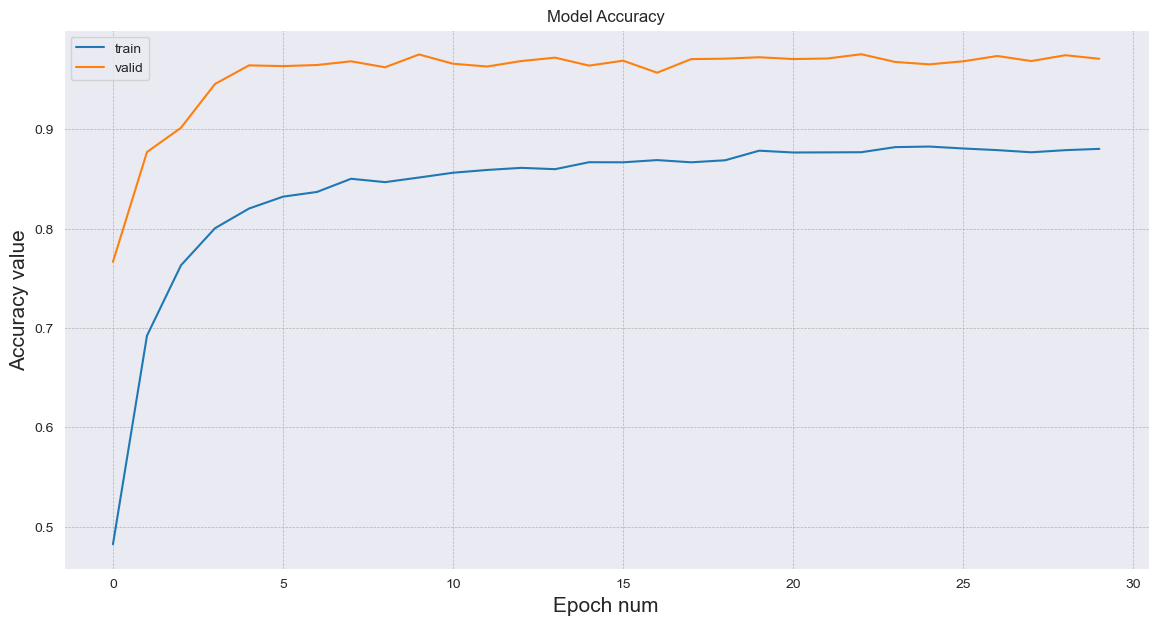

In [106]:
def plot_acc(acc_: dict) -> None:
    plt.rcParams['figure.figsize'] = (14, 7)
    for experiment_id in acc_.keys():
        plt.plot(acc_[experiment_id], label=experiment_id)
    plt.grid(linestyle='--', linewidth=0.5, color='.7')
    
    plt.title('Model Accuracy')
    plt.xlabel('Epoch num', fontsize=15)
    plt.ylabel('Accuracy value', fontsize=15)
    plt.legend(loc='upper left')
    
    plt.show()

Видим, что основной результат быд получен на 4-ой эпохе. Далее качество модели очень медленно улучшается (можно сказать - выходит на плато).

#### tf_efficientnet_b0

---

Теперь попробуем модель `tf_efficientnet_b0`, чтобы сравнить качество.
На данный момент, семейство данной модели имеет Top 1 Accuracy: 88.35% (Top 5 Accuracy: 98.66%) на ImageNet.

Изучим подробнее модель `tf_efficientnet_b0`:

In [169]:
CFG.model_name = "tf_efficientnet_b0"
NUM_CLASSES = len(train_dataset.classes)
model_test = timm.create_model(CFG.model_name, pretrained=True, num_classes=len(train_dataset.classes))
summary(model=model_test,
        input_size=(NUM_CLASSES, 3, 160, 160),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
EfficientNet                                  [10, 3, 160, 160]    [10, 10]             --                   True
├─Conv2dSame: 1-1                             [10, 3, 160, 160]    [10, 32, 80, 80]     864                  True
├─BatchNormAct2d: 1-2                         [10, 32, 80, 80]     [10, 32, 80, 80]     64                   True
│    └─Identity: 2-1                          [10, 32, 80, 80]     [10, 32, 80, 80]     --                   --
│    └─SiLU: 2-2                              [10, 32, 80, 80]     [10, 32, 80, 80]     --                   --
├─Sequential: 1-3                             [10, 32, 80, 80]     [10, 320, 5, 5]      --                   True
│    └─Sequential: 2-3                        [10, 32, 80, 80]     [10, 16, 80, 80]     --                   True
│    │    └─DepthwiseSeparableConv: 3-1       [10, 32, 80, 80]     [10, 16, 80, 80]    

У модели 4 020 358 параметров, что почти в 6 раз меньше, чем у `resnet50`. Посмотрим, как она справится с нашей задачей.

Так же, изменим оптимизатор на `RMSProp` и шедулер на `CosineAnnealingWarmRestarts`.

И, т.к. результат на первой мы получили уже на 10-ой эпохе, то и здесь уменьшим кол-во эпох до 10.

In [154]:
model = MyNet(CFG.model_name, pretrained=True, efficient_net=True, value=False).to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(optimizer, CFG.scheduler[3])

In [155]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs_=CFG.epochs)

Epoch 1/10:


100%|██████████| 1184/1184 [01:07<00:00, 17.59it/s]


train loss: 1.96 accuracy: 0.55


100%|██████████| 491/491 [00:17<00:00, 27.41it/s]


valid loss: 1.62 accuracy: 0.86
Epoch 1 - Save Best Accuracy: 0.86 Model

Epoch 2/10:


100%|██████████| 1184/1184 [00:59<00:00, 19.77it/s]


train loss: 1.77 accuracy: 0.71


100%|██████████| 491/491 [00:15<00:00, 32.55it/s]


valid loss: 1.59 accuracy: 0.87
Epoch 2 - Save Best Accuracy: 0.87 Model

Epoch 3/10:


100%|██████████| 1184/1184 [00:58<00:00, 20.08it/s]


train loss: 1.74 accuracy: 0.73


100%|██████████| 491/491 [00:15<00:00, 31.17it/s]


valid loss: 1.58 accuracy: 0.88
Epoch 3 - Save Best Accuracy: 0.88 Model

Epoch 4/10:


100%|██████████| 1184/1184 [01:00<00:00, 19.60it/s]


train loss: 1.72 accuracy: 0.74


100%|██████████| 491/491 [00:16<00:00, 30.65it/s]


valid loss: 1.59 accuracy: 0.87
Epoch 5/10:


100%|██████████| 1184/1184 [00:59<00:00, 19.82it/s]


train loss: 1.72 accuracy: 0.75


100%|██████████| 491/491 [00:16<00:00, 30.32it/s]


valid loss: 1.58 accuracy: 0.87
Epoch 6/10:


100%|██████████| 1184/1184 [01:00<00:00, 19.59it/s]


train loss: 1.72 accuracy: 0.75


100%|██████████| 491/491 [00:16<00:00, 30.21it/s]


valid loss: 1.57 accuracy: 0.89
Epoch 6 - Save Best Accuracy: 0.89 Model

Epoch 7/10:


100%|██████████| 1184/1184 [01:00<00:00, 19.69it/s]


train loss: 1.69 accuracy: 0.77


100%|██████████| 491/491 [00:15<00:00, 30.85it/s]


valid loss: 1.52 accuracy: 0.94
Epoch 7 - Save Best Accuracy: 0.94 Model

Epoch 8/10:


100%|██████████| 1184/1184 [00:59<00:00, 19.93it/s]


train loss: 1.67 accuracy: 0.79


100%|██████████| 491/491 [00:15<00:00, 31.87it/s]


valid loss: 1.51 accuracy: 0.96
Epoch 8 - Save Best Accuracy: 0.96 Model

Epoch 9/10:


100%|██████████| 1184/1184 [00:59<00:00, 19.78it/s]


train loss: 1.67 accuracy: 0.80


100%|██████████| 491/491 [00:15<00:00, 31.15it/s]


valid loss: 1.51 accuracy: 0.96
Epoch 10/10:


100%|██████████| 1184/1184 [00:59<00:00, 19.75it/s]


train loss: 1.66 accuracy: 0.80


100%|██████████| 491/491 [00:15<00:00, 32.36it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 10 - Save Best Accuracy: 0.96 Model


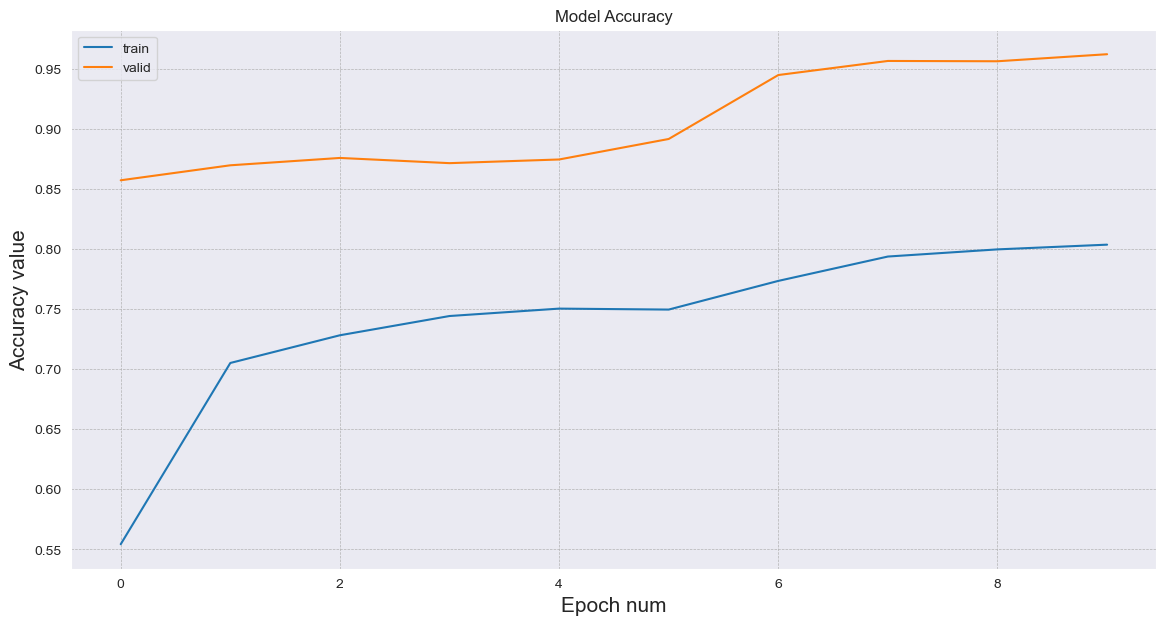

In [170]:
plot_acc(acc)

На трейне результаты смогли достичь лишь 0.8, а на валидации - 0.96. Видим, что модель не справилась с задачей на заданном кол-ве эпох. Хотя, относительно своего размера (в 5-6 раз меньше), и средней скорости обучения, модель показала неплохой результат.

### Train with new parameters

---

Попробуем изменить кол-во батчей и проверить - улучшится ли качество модели. 

Как я писал ранее оптимальный размер батча равен 32. Тогда как размеры 8 и 2048 считаются вариантами хуже.

#### tf_efficientnet_b0

---


In [174]:
CFG.batch_size = 32
CFG.epochs = 10

train_loader = create_data_loader(TRAIN)
valid_loader = create_data_loader(VALID)

print("Train and Valid datasets are loaded:\n")
print("{:<7s}{:>10s}{:>10s}".format("Dataset", "Batches", "Pictures")), print("-" * 28)
print("{:<7s}{:>10d}{:>10d}".format(TRAIN.capitalize(), len(train_loader), len(train_dataset)))
print("{:<7s}{:>10d}{:>10d}".format(VALID.capitalize(), len(valid_loader), len(val_dataset)))

model = MyNet(CFG.model_name, pretrained=True, efficient_net=True, value=False).to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(optimizer, CFG.scheduler[3])

model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs_=CFG.epochs)

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train         296      9469
Valid         123      3925
Epoch 1/10:


100%|██████████| 296/296 [00:51<00:00,  5.78it/s]


train loss: 1.92 accuracy: 0.59


100%|██████████| 123/123 [00:19<00:00,  6.31it/s]


valid loss: 1.63 accuracy: 0.88
Epoch 1 - Save Best Accuracy: 0.88 Model

Epoch 2/10:


100%|██████████| 296/296 [00:41<00:00,  7.21it/s]


train loss: 1.71 accuracy: 0.77


100%|██████████| 123/123 [00:11<00:00, 10.82it/s]


valid loss: 1.58 accuracy: 0.88
Epoch 2 - Save Best Accuracy: 0.88 Model

Epoch 3/10:


100%|██████████| 296/296 [00:41<00:00,  7.20it/s]


train loss: 1.67 accuracy: 0.81


100%|██████████| 123/123 [00:10<00:00, 11.38it/s]


valid loss: 1.54 accuracy: 0.95
Epoch 3 - Save Best Accuracy: 0.95 Model

Epoch 4/10:


100%|██████████| 296/296 [00:40<00:00,  7.26it/s]


train loss: 1.65 accuracy: 0.83


100%|██████████| 123/123 [00:10<00:00, 11.45it/s]


valid loss: 1.53 accuracy: 0.95
Epoch 4 - Save Best Accuracy: 0.95 Model

Epoch 5/10:


100%|██████████| 296/296 [00:42<00:00,  7.05it/s]


train loss: 1.64 accuracy: 0.84


100%|██████████| 123/123 [00:11<00:00, 11.16it/s]


valid loss: 1.53 accuracy: 0.96
Epoch 5 - Save Best Accuracy: 0.96 Model

Epoch 6/10:


100%|██████████| 296/296 [00:41<00:00,  7.09it/s]


train loss: 1.63 accuracy: 0.85


100%|██████████| 123/123 [00:11<00:00, 11.05it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 6 - Save Best Accuracy: 0.96 Model

Epoch 7/10:


100%|██████████| 296/296 [00:42<00:00,  7.03it/s]


train loss: 1.60 accuracy: 0.87


100%|██████████| 123/123 [00:11<00:00, 10.94it/s]


valid loss: 1.50 accuracy: 0.97
Epoch 7 - Save Best Accuracy: 0.97 Model

Epoch 8/10:


100%|██████████| 296/296 [00:41<00:00,  7.17it/s]


train loss: 1.60 accuracy: 0.87


100%|██████████| 123/123 [00:11<00:00, 10.78it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 8 - Save Best Accuracy: 0.97 Model

Epoch 9/10:


100%|██████████| 296/296 [00:40<00:00,  7.25it/s]


train loss: 1.59 accuracy: 0.88


100%|██████████| 123/123 [00:11<00:00, 10.88it/s]


valid loss: 1.49 accuracy: 0.97
Epoch 10/10:


100%|██████████| 296/296 [00:41<00:00,  7.13it/s]


train loss: 1.59 accuracy: 0.88


100%|██████████| 123/123 [00:11<00:00, 10.81it/s]

valid loss: 1.49 accuracy: 0.97


Видим, что качество модели на трейне улучшилось (до 0.88), и на валидации - до 0.97, что уже близко к необходимому результату.

Посмотрим на графики обучения:

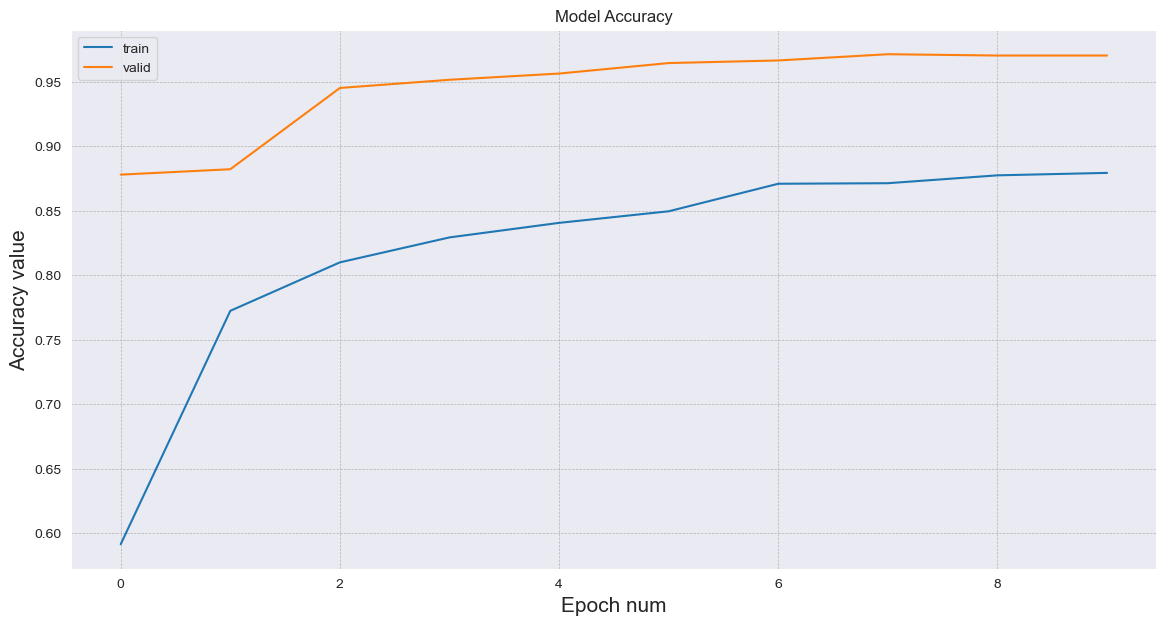

In [180]:
plot_acc(acc)

Приближение к 0.95 произошло очень быстро - на 2-ой эпохе, но дальше качество модели улучшалось очень медленно.

#### resnet50

---

Теперь попробуем модель `resnet50` с новыми параметрами.

Изменим оптимизатор на `RMSProp` и шедулер на `CosineAnnealingWarmRestarts`.
Дополнительно, изменим кол-во эпох на 10, а кол-во батчей - на 64.

In [182]:
CFG.model_name = "resnet50"
CFG.batch_size = 64
CFG.epochs = 10

train_loader = create_data_loader(TRAIN)
valid_loader = create_data_loader(VALID)

print("Train and Valid datasets are loaded:\n")
print("{:<7s}{:>10s}{:>10s}".format("Dataset", "Batches", "Pictures")), print("-" * 28)
print("{:<7s}{:>10d}{:>10d}".format(TRAIN.capitalize(), len(train_loader), len(train_dataset)))
print("{:<7s}{:>10d}{:>10d}".format(VALID.capitalize(), len(valid_loader), len(val_dataset)))

model = MyNet(CFG.model_name, pretrained=True, efficient_net=False, value=False).to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(optimizer, CFG.scheduler[3])

model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs_=CFG.epochs)

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train         148      9469
Valid          62      3925
Epoch 1/10:


100%|██████████| 148/148 [01:08<00:00,  2.16it/s]


train loss: 2.03 accuracy: 0.51


100%|██████████| 62/62 [00:22<00:00,  2.78it/s]


valid loss: 1.73 accuracy: 0.84
Epoch 1 - Save Best Accuracy: 0.84 Modelresnet50
Epoch 2/10:


100%|██████████| 148/148 [01:08<00:00,  2.15it/s]


train loss: 1.76 accuracy: 0.74


100%|██████████| 62/62 [00:21<00:00,  2.82it/s]


valid loss: 1.63 accuracy: 0.87
Epoch 2 - Save Best Accuracy: 0.87 Modelresnet50

Epoch 3/10:


100%|██████████| 148/148 [01:07<00:00,  2.19it/s]


train loss: 1.70 accuracy: 0.79


100%|██████████| 62/62 [00:21<00:00,  2.88it/s]


valid loss: 1.61 accuracy: 0.87
Epoch 3 - Save Best Accuracy: 0.87 Modelresnet50

Epoch 4/10:


100%|██████████| 148/148 [01:08<00:00,  2.16it/s]


train loss: 1.68 accuracy: 0.80


100%|██████████| 62/62 [00:23<00:00,  2.66it/s]


valid loss: 1.60 accuracy: 0.87
Epoch 4 - Save Best Accuracy: 0.87 Modelresnet50

Epoch 5/10:


100%|██████████| 148/148 [01:11<00:00,  2.08it/s]


train loss: 1.68 accuracy: 0.81


100%|██████████| 62/62 [00:22<00:00,  2.74it/s]


valid loss: 1.60 accuracy: 0.87
Epoch 5 - Save Best Accuracy: 0.87 Modelresnet50

Epoch 6/10:


100%|██████████| 148/148 [01:11<00:00,  2.07it/s]


train loss: 1.67 accuracy: 0.81


100%|██████████| 62/62 [00:23<00:00,  2.69it/s]


valid loss: 1.58 accuracy: 0.89
Epoch 6 - Save Best Accuracy: 0.89 Modelresnet50

Epoch 7/10:


100%|██████████| 148/148 [01:11<00:00,  2.06it/s]


train loss: 1.64 accuracy: 0.85


100%|██████████| 62/62 [00:22<00:00,  2.76it/s]


valid loss: 1.54 accuracy: 0.94
Epoch 7 - Save Best Accuracy: 0.94 Modelresnet50

Epoch 8/10:


100%|██████████| 148/148 [01:09<00:00,  2.13it/s]


train loss: 1.61 accuracy: 0.87


100%|██████████| 62/62 [00:21<00:00,  2.82it/s]


valid loss: 1.52 accuracy: 0.96
Epoch 8 - Save Best Accuracy: 0.96 Modelresnet50

Epoch 9/10:


100%|██████████| 148/148 [01:08<00:00,  2.15it/s]


train loss: 1.60 accuracy: 0.88


100%|██████████| 62/62 [00:22<00:00,  2.81it/s]


valid loss: 1.51 accuracy: 0.96
Epoch 9 - Save Best Accuracy: 0.96 Modelresnet50

Epoch 10/10:


100%|██████████| 148/148 [01:11<00:00,  2.07it/s]


train loss: 1.59 accuracy: 0.89


100%|██████████| 62/62 [00:22<00:00,  2.79it/s]

valid loss: 1.51 accuracy: 0.96


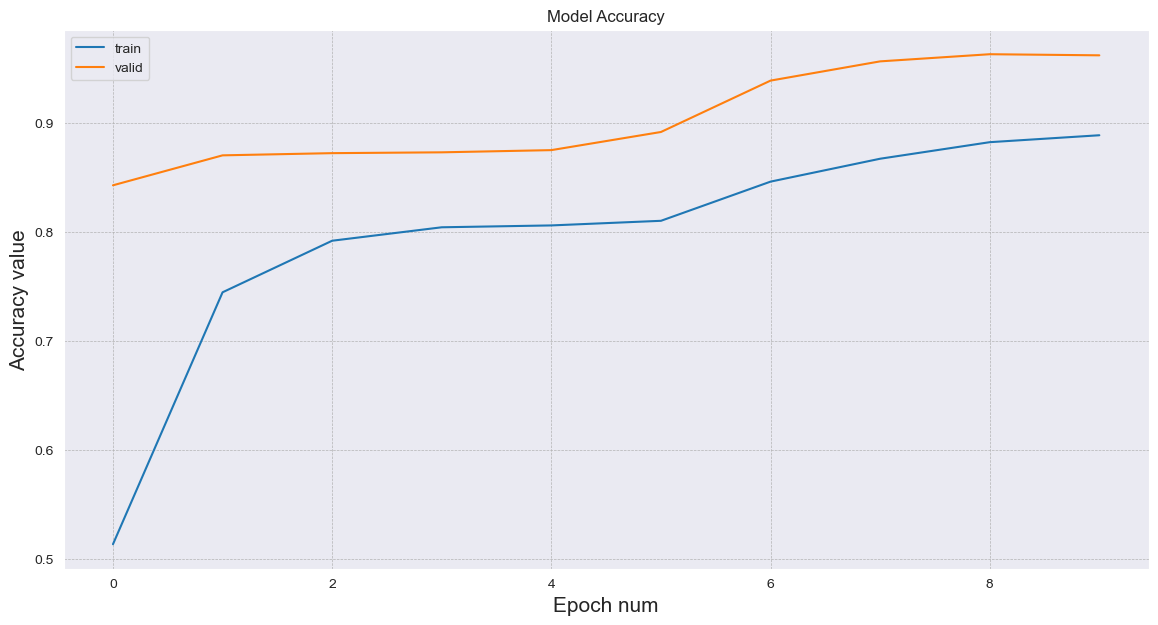

In [184]:
plot_acc(acc)

Трейн и валидация смогли достичь 0.89 и 0.96 соответственно. Видим, что модель очень улучшилась на трейне, но не достаточно на валидации.

Попробуем новые архитектуры моделей.

#### resnet101

---


In [194]:
CFG.model_name = "resnet101"

NUM_CLASSES = len(train_dataset.classes)
model_test = timm.create_model(CFG.model_name, pretrained=True, num_classes=len(train_dataset.classes))
summary(model=model_test,
        input_size=(NUM_CLASSES, 3, 160, 160),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [10, 3, 160, 160]    [10, 10]             --                   True
├─Conv2d: 1-1                            [10, 3, 160, 160]    [10, 64, 80, 80]     9,408                True
├─BatchNorm2d: 1-2                       [10, 64, 80, 80]     [10, 64, 80, 80]     128                  True
├─ReLU: 1-3                              [10, 64, 80, 80]     [10, 64, 80, 80]     --                   --
├─MaxPool2d: 1-4                         [10, 64, 80, 80]     [10, 64, 40, 40]     --                   --
├─Sequential: 1-5                        [10, 64, 40, 40]     [10, 256, 40, 40]    --                   True
│    └─Bottleneck: 2-1                   [10, 64, 40, 40]     [10, 256, 40, 40]    --                   True
│    │    └─Conv2d: 3-1                  [10, 64, 40, 40]     [10, 64, 40, 40]     4,096                True
│    │    └─BatchN

Модель `resnet101` имеет 42 520 650 параметров, что почти в 2 раз больше, чем у `resnet50`. Посмотрим, улучшится ли качество предсказаний.


In [195]:
CFG.batch_size = 64
CFG.epochs = 10

train_loader = create_data_loader(TRAIN)
valid_loader = create_data_loader(VALID)

print("Train and Valid datasets are loaded:\n")
print("{:<7s}{:>10s}{:>10s}".format("Dataset", "Batches", "Pictures")), print("-" * 28)
print("{:<7s}{:>10d}{:>10d}".format(TRAIN.capitalize(), len(train_loader), len(train_dataset)))
print("{:<7s}{:>10d}{:>10d}".format(VALID.capitalize(), len(valid_loader), len(val_dataset)))

model = MyNet(CFG.model_name, pretrained=True, efficient_net=False, value=False).to(DEVICE)
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(optimizer, CFG.scheduler[3])

model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs_=CFG.epochs)

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train         148      9469
Valid          62      3925
Epoch 1/10:


100%|██████████| 148/148 [01:44<00:00,  1.42it/s]


train loss: 1.99 accuracy: 0.59


100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


valid loss: 1.69 accuracy: 0.82
Epoch 1 - Save Best Accuracy: 0.82 Model resnet101
Epoch 2/10:


100%|██████████| 148/148 [01:37<00:00,  1.52it/s]


train loss: 1.73 accuracy: 0.77


100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


valid loss: 1.61 accuracy: 0.87
Epoch 2 - Save Best Accuracy: 0.87 Model resnet101
Epoch 3/10:


100%|██████████| 148/148 [01:40<00:00,  1.47it/s]


train loss: 1.68 accuracy: 0.80


100%|██████████| 62/62 [00:33<00:00,  1.85it/s]


valid loss: 1.60 accuracy: 0.87
Epoch 4/10:


100%|██████████| 148/148 [01:39<00:00,  1.48it/s]


train loss: 1.66 accuracy: 0.82


100%|██████████| 62/62 [00:32<00:00,  1.89it/s]


valid loss: 1.58 accuracy: 0.92
Epoch 4 - Save Best Accuracy: 0.92 Model resnet101
Epoch 5/10:


100%|██████████| 148/148 [01:38<00:00,  1.50it/s]


train loss: 1.65 accuracy: 0.84


100%|██████████| 62/62 [00:32<00:00,  1.91it/s]


valid loss: 1.56 accuracy: 0.93
Epoch 5 - Save Best Accuracy: 0.93 Model resnet101
Epoch 6/10:


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


train loss: 1.64 accuracy: 0.85


100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


valid loss: 1.52 accuracy: 0.95
Epoch 6 - Save Best Accuracy: 0.95 Model resnet101
Epoch 7/10:


100%|██████████| 148/148 [01:36<00:00,  1.53it/s]


train loss: 1.61 accuracy: 0.87


100%|██████████| 62/62 [00:32<00:00,  1.89it/s]


valid loss: 1.52 accuracy: 0.95
Epoch 7 - Save Best Accuracy: 0.95 Model resnet101
Epoch 8/10:


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


train loss: 1.59 accuracy: 0.89


100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


valid loss: 1.51 accuracy: 0.96
Epoch 8 - Save Best Accuracy: 0.96 Model resnet101
Epoch 9/10:


100%|██████████| 148/148 [01:38<00:00,  1.50it/s]


train loss: 1.58 accuracy: 0.89


100%|██████████| 62/62 [00:32<00:00,  1.89it/s]


valid loss: 1.50 accuracy: 0.96
Epoch 9 - Save Best Accuracy: 0.96 Model resnet101
Epoch 10/10:


100%|██████████| 148/148 [01:39<00:00,  1.49it/s]


train loss: 1.57 accuracy: 0.90


100%|██████████| 62/62 [00:32<00:00,  1.89it/s]

valid loss: 1.51 accuracy: 0.96


К сожалению, модель не смогла достичь необходимой точности на валидации. На трейне результаты смогли достичь 0.9, а на валидации - 0.96.

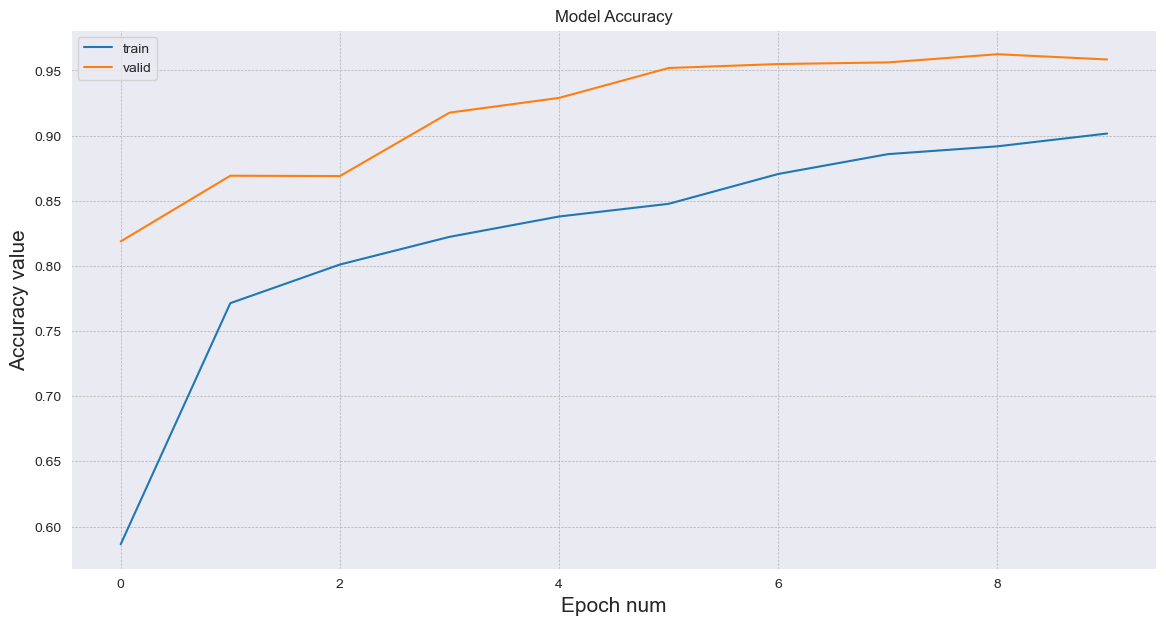

In [196]:
plot_acc(acc)

# Result

---

В результате мы смогли достичь необходимой точности на валидации (0.98) на 10-ой эпохе, только используя модель `resnet50` с параметрами:
- batch_size = 8
- epochs = 10
- optimizer = AdamW
- scheduler = StepLR
- loss = CrossEntropyLoss
- pretrained = True
- efficient_net = False

При этом, мы смогли достичь точности на трейне - 0.9 на 10-ой эпохе модели `resnet101` с параметрами:
- batch_size = 64
- epochs = 10
- optimizer = RMSprop
- scheduler = CosineAnnealingWarmRestarts
- loss = CrossEntropyLoss
- pretrained = True
- efficient_net = False